In [3]:
from monte import Monte

In [1]:
import pandas as pd

In [2]:
result_path = "/grain/mk98/cancer-methyl/pcr_results/20251029_225637/"
pd.read_csv(result_path + "summary.csv")

,cancer,n_train,n_test,test_rmse,test_r2,test_pearson
0,ACC,56,24,0.045061,0.806306,0.898636
1,BLCA,290,124,0.087740,0.552899,0.746669
2,BRCA,550,235,0.069688,0.760674,0.872658
3,CESC,214,91,0.081609,0.541030,0.758448
4,COAD,216,93,0.070596,0.578856,0.766633
5,GBM,99,43,0.059660,0.794291,0.915179
6,HNSC,370,158,0.071698,0.674661,0.822681
7,KICH,46,20,0.051025,0.601196,0.862869
8,KIRC,227,97,0.061571,0.775517,0.886399
9,KIRP,192,83,0.072895,0.672988,0.822065


In [38]:
cancer = "BRCA"

train_path = "/grain/mk98/cancer-methyl/TCGA_Methylation_450K/processed/tumor/train"
test_path = "/grain/mk98/cancer-methyl/TCGA_Methylation_450K/processed/tumor/test"
meta_path = "/grain/mk98/cancer-methyl/TCGA_Methylation_450K/processed/metadata"
xy_probes = pd.read_csv(f"/grain/mk98/cancer-methyl/probe_selection_files/xy_probes.txt", header=None)[0].tolist()

train_beta = pd.read_parquet(f"{train_path}/{cancer}_beta.parquet")
train_beta = train_beta.dropna()
train_beta = train_beta.drop(columns=xy_probes, errors='ignore')

test_beta = pd.read_parquet(f"{test_path}/{cancer}_beta.parquet")
test_beta = test_beta.dropna()
test_beta = test_beta.drop(columns=xy_probes, errors='ignore')

cancer_meta = pd.read_csv(f"{meta_path}/tumor_metadata.csv").set_index("Barcode")
train_meta = cancer_meta.loc[train_beta.index]
test_meta = cancer_meta.loc[test_beta.index]

print(train_beta.shape, train_meta.shape)
print(test_beta.shape, test_meta.shape)

(550, 293139) (550, 14)
(235, 293139) (235, 14)


In [116]:
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from scipy.special import expit  # logistic / inverse logit

# ---------------------------
# Helpers
# ---------------------------

def beta_to_m(beta_df, eps=1e-3):
    """Convert β to M-values (clip to avoid infinities)."""
    X = beta_df.clip(eps, 1 - eps)
    return np.log2(X / (1 - X))

import numpy as np
from sklearn.metrics import mean_squared_error

def rmse_function(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def choose_pcr_components(M_train, p_train, max_pc=60, cv_splits=5, random_state=0):
    """
    Cross-validate number of PCs (1..max_pc or limited by rank) for PCR.
    Criterion: lowest RMSE (reports tie-broken by higher R^2).
    """
    n = M_train.shape[0]
    rank_cap = min(max_pc, n - 2)  # leave a little dof
    pca = PCA(n_components=rank_cap, random_state=random_state)
    PCs = pca.fit_transform(M_train)

    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    best_k, best_rmse, best_r2 = 5, float("inf"), -np.inf

    for k in range(2, rank_cap + 1):
        preds, obs = [], []
        for tr, va in kf.split(PCs):
            lr = LinearRegression()
            lr.fit(PCs[tr, :k], p_train.iloc[tr])
            pv = lr.predict(PCs[va, :k])
            preds.append(pv)
            obs.append(p_train.iloc[va].values)
        preds = np.concatenate(preds)
        obs = np.concatenate(obs)
        rmse = rmse_function(obs, preds)
        r2 = r2_score(obs, preds)
        if (rmse < best_rmse - 1e-6) or (np.isclose(rmse, best_rmse) and r2 > best_r2):
            best_k, best_rmse, best_r2 = k, rmse, r2

    return 60

def pcr_fit_predict(M_train, p_train, M_test, n_pc):
    """Fit PCR with n_pc PCs and predict purity for train/test."""
    pca = PCA(n_components=n_pc, random_state=0)
    PCs_train = pca.fit_transform(M_train)
    PCs_test  = pca.transform(M_test)

    lr = LinearRegression()
    lr.fit(PCs_train, p_train.values)

    p_hat_train = lr.predict(PCs_train)
    p_hat_test  = lr.predict(PCs_test)

    # clip to [0,1]
    p_hat_train = np.clip(p_hat_train, 0, 1)
    p_hat_test  = np.clip(p_hat_test, 0, 1)

    return p_hat_train, p_hat_test, pca, lr

def m_to_beta(M_df):
    """Inverse logit base-2: β = 1 / (1 + 2^{-M})."""
    return 1.0 / (1.0 + np.power(2.0, -M_df))

# ---------------------------
# PIPELINE (assumes you already loaded train_beta/test_beta/train_meta/test_meta)
# ---------------------------

# 0) Purity column
purity_col = 'CPE'
p_train = train_meta[purity_col]
p_test_true = test_meta[purity_col] if purity_col in test_meta.columns else None

# 1) β → M
train_M = beta_to_m(train_beta)
test_M  = beta_to_m(test_beta)


In [117]:
# 2) PURITY ESTIMATION via PCR on M
n_pc = choose_pcr_components(train_M.values, p_train, max_pc=60, cv_splits=5, random_state=0)
p_hat_train, p_hat_test, pca_model, lr_head = pcr_fit_predict(train_M.values, p_train, test_M.values, n_pc)

# metrics (if ground-truth exists for test)
metrics = {}
from math import isnan
if p_test_true is not None and not p_test_true.isna().all():
    rmse = rmse_function(p_test_true.values, p_hat_test)
    r2   = r2_score(p_test_true.values, p_hat_test)
    metrics.update({"test_rmse": rmse, "test_r2": r2})

In [ ]:
def per_cpg_ols_params(M_train_df, p_train):
    """
    Fit OLS per CpG: M_ij = alpha_j + gamma_j * (p_i - pbar) + eps.
    Returns alpha (Series), gamma (Series), and pbar (float).
    """
    pbar = float(p_train.mean())
    p_c = (p_train - pbar).values.reshape(-1, 1)         # (n x 1)
    X = np.hstack([np.ones((len(p_train), 1)), p_c])     # (n x 2)
    M_train = M_train_df.values                          # (n x m)

    XtX = X.T @ X
    XtY = X.T @ M_train
    B   = np.linalg.solve(XtX, XtY)                      # (2 x m)

    alpha = pd.Series(B[0, :], index=M_train_df.columns)
    gamma = pd.Series(B[1, :], index=M_train_df.columns)
    return alpha, gamma, pbar

def apply_sample_specific_tumor_only(M_df, p_hat, gamma):
    """
    Sample-specific adjustment: M_tum[i, j] = M[i, j] + gamma[j] * (1 - p_hat[i]).
    M_df: (n x m) M-values for the cohort to adjust (e.g., test set)
    p_hat: length-n vector/Series of predicted purity for those samples
    gamma: length-m Series of per-CpG purity slopes from training
    """
    # broadcast (n x 1) * (1 x m) -> (n x m)
    shift = np.outer((1.0 - np.asarray(p_hat, dtype=float)), gamma.values)
    M_tum = M_df.values + shift
    return pd.DataFrame(M_tum, index=M_df.index, columns=M_df.ctrain_Molumns)

In [118]:
n_pc

60

In [119]:
# After you've trained PCR:
# pca_model: fitted PCA
# lr_head:   LinearRegression() fitted on PCs -> purity
# train_M, test_M: M-value DataFrames (β→M already done)
# p_hat_train, p_hat_test: PCR purity predictions

import numpy as np
import pandas as pd

def adjust_to_p1_via_pcr_vector(M_df, p_hat, pca_model, lr_head, clip_std=3.0):
    """
    Sample-specific tumor-only adjustment in M-space using the PCR purity vector.
    M_df: (n x m) DataFrame of M-values to adjust (train or test cohort)
    p_hat: length-n predicted purity for these samples (from PCR)
    pca_model: fitted sklearn PCA
    lr_head: fitted LinearRegression on PC scores -> purity
    clip_std: optional clipping of adjustment magnitude in SD units to avoid extreme moves
    """
    X = M_df.values.astype(float)
    mu = pca_model.mean_.astype(float)             # (m,)
    Xc = X - mu                                    # centered M

    # purity vector in CpG space: w = V^T beta
    # sklearn PCA: components_.shape = (n_components, m), rows are PCs (V_r)
    V = pca_model.components_                      # (r x m)
    beta = lr_head.coef_.reshape(-1, 1)            # (r x 1)
    w = (V.T @ beta).ravel()                       # (m,)

    # scale to avoid division by zero
    w_norm2 = float(np.dot(w, w)) + 1e-12

    # optional: mask tiny |w_j| so neutrality sites barely move
    # e.g., keep top k% by |w| or threshold by percentile
    # thresh = np.percentile(np.abs(w), 50)
    # w = np.where(np.abs(w) >= thresh, w, 0.0)

    # per-sample step size α_i so that w^T Δx_i = 1 - p_hat_i
    alpha = (1.0 - np.asarray(p_hat, dtype=float)) / w_norm2   # (n,)

    # optional: clip large adjustments based on dispersion of projections
    if clip_std is not None:
        proj_sd = np.std(Xc @ (w / np.sqrt(w_norm2))) + 1e-8
        max_alpha = clip_std * proj_sd / np.sqrt(w_norm2)
        alpha = np.clip(alpha, -max_alpha, max_alpha)

    # ΔX = α[:, None] * w[None, :]
    dX = np.outer(alpha, w)

    Xc_tum = Xc + dX
    M_tum = Xc_tum + mu

    M_tum_df = pd.DataFrame(M_tum, index=M_df.index, columns=M_df.columns)
    return M_tum_df

# Example usage on TEST:
M_tumor_test_pcr = adjust_to_p1_via_pcr_vector(test_M, p_hat_test, pca_model, lr_head)


In [120]:
pca_model.explained_variance_ratio_

array([0.12156084, 0.09372383, 0.0583164 , 0.03657265, 0.02183568,
       0.01992879, 0.01834553, 0.01447947, 0.0138664 , 0.01099058,
       0.01018241, 0.00871165, 0.00825422, 0.00754729, 0.00730538,
       0.00700158, 0.00653895, 0.00630588, 0.00571348, 0.00559368,
       0.00513854, 0.00492214, 0.00467016, 0.00451061, 0.00439912,
       0.00420904, 0.00394559, 0.00385177, 0.00380344, 0.00361486,
       0.00355466, 0.00349958, 0.00338431, 0.00333415, 0.00323551,
       0.00314703, 0.00303232, 0.00299747, 0.0029469 , 0.00292038,
       0.00285217, 0.00271879, 0.00263849, 0.00262194, 0.00255674,
       0.00251867, 0.00243828, 0.0024217 , 0.00240689, 0.00232601,
       0.00230419, 0.0022719 , 0.00224032, 0.00219588, 0.00216774,
       0.00214915, 0.00209567, 0.00206972, 0.00203963, 0.00200122])

(array([7.0000e+00, 3.3000e+01, 1.0800e+02, 2.0100e+02, 2.8800e+02,
        3.8500e+02, 5.0700e+02, 6.8500e+02, 8.2700e+02, 1.0080e+03,
        1.1850e+03, 1.4630e+03, 1.8280e+03, 2.2550e+03, 2.6420e+03,
        3.2110e+03, 3.8970e+03, 4.8710e+03, 6.3530e+03, 7.9810e+03,
        1.0641e+04, 1.4071e+04, 1.7493e+04, 2.0734e+04, 2.2988e+04,
        2.3791e+04, 2.3616e+04, 2.2276e+04, 2.0177e+04, 1.7282e+04,
        1.4452e+04, 1.1455e+04, 8.5180e+03, 6.5580e+03, 4.8700e+03,
        3.5290e+03, 2.7160e+03, 2.0270e+03, 1.5360e+03, 1.2570e+03,
        9.4800e+02, 7.6900e+02, 5.1200e+02, 4.3600e+02, 2.9800e+02,
        2.0500e+02, 1.5000e+02, 6.9000e+01, 2.8000e+01, 2.0000e+00]),
 array([-0.75589304, -0.72570454, -0.69551603, -0.66532752, -0.63513901,
        -0.6049505 , -0.57476199, -0.54457348, -0.51438497, -0.48419646,
        -0.45400795, -0.42381944, -0.39363093, -0.36344242, -0.33325391,
        -0.3030654 , -0.2728769 , -0.24268839, -0.21249988, -0.18231137,
        -0.15212286, -0.12

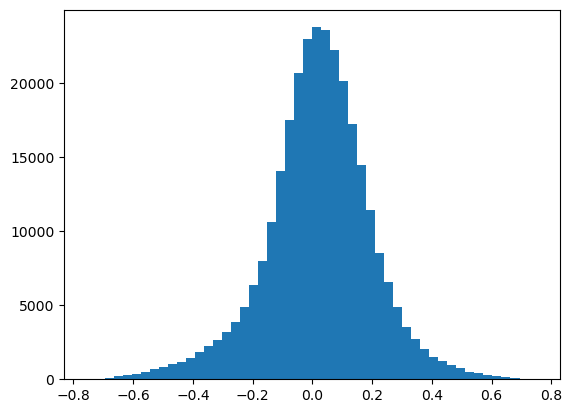

In [121]:
p_corr_pcr = M_tumor_test_pcr.corrwith(p_test_true)
plt.hist(p_corr_pcr, bins=50)

In [98]:
# 3) TUMOR-ONLY ADJUSTMENT in M via probe-wise OLS
alpha_series, gamma_series, pbar = per_cpg_ols_params(train_M, p_train)

# 4) Back to β for tumor-only
M_tumor_test = apply_sample_specific_tumor_only(test_M, p_hat_test, gamma_series)

# Back to β
beta_tumor_test = m_to_beta(M_tumor_test).clip(1e-6, 1-1e-6)

pd.DataFrame({
    "Barcode": test_beta.index,
    "p_hat": p_hat_test
}).set_index("Barcode")

# pd.DataFrame({
#     "Barcode": test_beta.index,
#     "p_hat": p_hat_test
# }).set_index("Barcode").to_csv(os.path.join(out_dir, f"{cancer}_purity_predictions.csv"))

# beta_tumor_test.to_parquet(os.path.join(out_dir, f"{cancer}_tumor_only_beta.parquet"))

# # Optional: save parameters for auditing
# alpha_series.to_frame("alpha").to_csv(os.path.join(out_dir, f"{cancer}_ols_alpha.csv"))
# gamma_series.to_frame("gamma_purity").to_csv(os.path.join(out_dir, f"{cancer}_ols_gamma.csv"))

# 6) Quick printouts
print(f"[PCR] {cancer}: selected PCs = {n_pc}")
if metrics:
    print(f"[PCR] test RMSE = {metrics['test_rmse']:.4f}, R2 = {metrics['test_r2']:.3f}")
# print(f"Saved: purity CSV and tumor-only β parquet to: {out_dir}")

[PCR] BRCA: selected PCs = 26
[PCR] test RMSE = 0.0697, R2 = 0.761


In [87]:
B = np.hstack([alpha_series.values.reshape(-1, 1), gamma_series.values.reshape(-1, 1)])
B

array([[-0.71477023, -2.59883206],
       [ 1.66439591,  1.56916858],
       [ 0.90840639, -0.25389549],
       ...,
       [ 3.30919162,  2.82194022],
       [-4.83551764, -0.22605909],
       [-5.82385023, -0.01488149]], shape=(293139, 2))

In [91]:
P_lin = np.linalg.solve(B @ B.T, test_M.values @ B.T)

MemoryError: Unable to allocate 640. GiB for an array with shape (293139, 293139) and data type float64

In [99]:
test_M.shape

(235, 293139)

In [101]:
np.linalg.pinv(B).shape

(2, 293139)

In [102]:
P_lin = test_M.values @ np.linalg.pinv(B).T

In [104]:
P_lin[:,1] + pbar

array([0.64932576, 0.89717352, 0.53460146, 0.81716732, 0.8375964 ,
       0.80433752, 0.7929969 , 0.75799951, 0.54419002, 0.83211505,
       1.16895487, 0.47141638, 0.95139476, 0.74756024, 0.91809627,
       0.78667873, 0.66813739, 0.732049  , 0.91592195, 0.38648289,
       0.698959  , 0.49787465, 0.75520278, 0.9330233 , 0.64720672,
       0.79661416, 0.53298461, 0.79474585, 0.79482354, 0.92181408,
       0.69702142, 0.76974874, 0.8046835 , 0.54312317, 0.84383757,
       0.97476294, 0.57593978, 0.83568594, 0.89938255, 0.5299102 ,
       0.58493524, 0.81085155, 0.62360437, 0.40729695, 0.87414648,
       0.97620575, 0.92255186, 0.73815055, 0.59273483, 0.69740453,
       0.59264355, 0.88787942, 0.62928559, 0.62894588, 0.8405545 ,
       0.56319197, 0.65134821, 1.04666141, 0.5381848 , 0.70483963,
       0.7153488 , 0.3651846 , 0.5589037 , 0.43070954, 0.6421432 ,
       0.92806897, 0.75654853, 0.6954459 , 0.86431845, 0.89145419,
       0.67294551, 0.73571012, 0.455563  , 0.53554006, 0.86087

Text(0, 0.5, 'Predicted purity (linear algebra)')

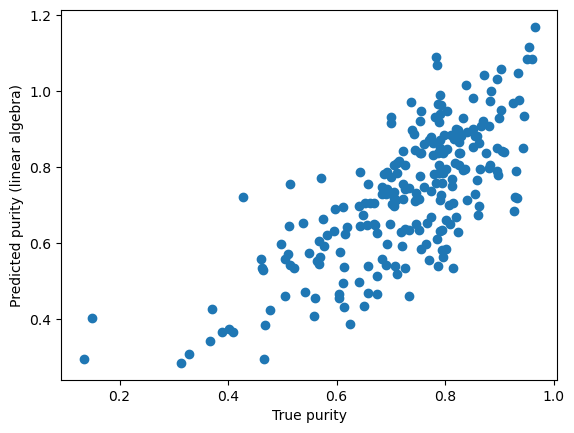

In [105]:
plt.scatter(p_test_true, P_lin[:,1] + pbar)
plt.xlabel("True purity")
plt.ylabel("Predicted purity (linear algebra)")

In [107]:
(P_lin[:,1] + pbar).shape

(235,)

In [106]:
pearsonr(p_test_true, P_lin[:,1] + pbar)

PearsonRResult(statistic=np.float64(0.7474820574734891), pvalue=np.float64(2.8240763915783223e-43))

In [66]:
from scipy.stats import pearsonr, spearmanr
pearson_corr = pearsonr(p_test_true.values, p_hat_test)[0]
spearman_corr = spearmanr(p_test_true.values, p_hat_test)[0]
print(f"Pearson correlation: {pearson_corr:.4f}")
print(f"Spearman correlation: {spearman_corr:.4f}")

Pearson correlation: 0.8727
Spearman correlation: 0.8505


In [53]:
M_tumor_test.shape

(235, 293139)

In [54]:
p_test_true.shape

(235,)

In [69]:
import matplotlib.pyplot as plt

In [ ]:
train_corr=train_M.corrwith(p_train, axis=0)

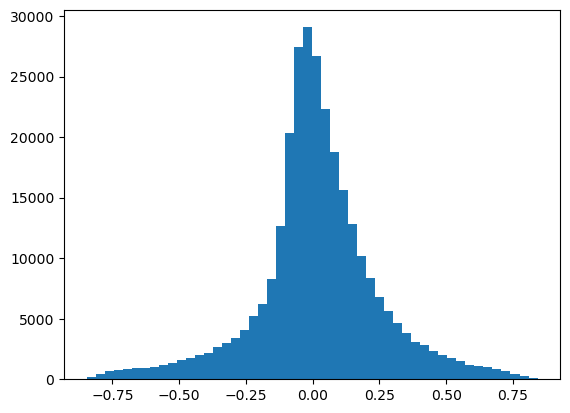

In [70]:
plt.hist(train_corr, bins=50)
None

In [67]:
tumor_corr = M_tumor_test.corrwith(p_test_true, axis=0)

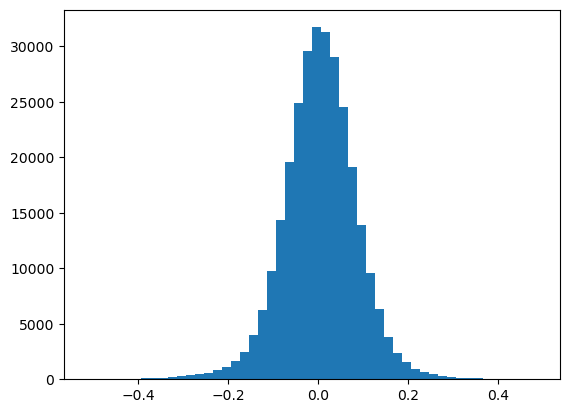

In [ ]:
plt.hist(tumor_corr, bins=50)
None

In [71]:
alpha_series, gamma_series, pbar = per_cpg_ols_params(train_M, p_train)
M_tumor_train = apply_sample_specific_tumor_only(train_M, p_hat_train, gamma_series)

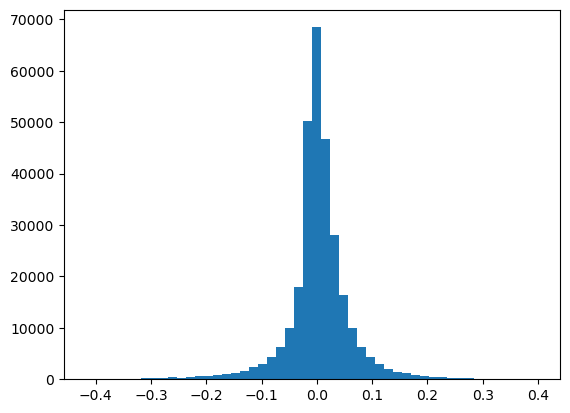

In [72]:
train_tumor_corr = M_tumor_train.corrwith(p_train, axis=0)
plt.hist(train_tumor_corr, bins=50)
None

In [74]:
M_tumor_train

CpG_ID,cg16619049,cg18147296,cg13938959,cg12445832,cg23999112,cg11527153,cg27573606,cg04195702,cg08128007,cg23733394,...,cg09635994,cg19004771,cg20569369,cg26034629,cg25232725,cg05615487,cg22122449,cg08423507,cg09007244,cg19565306
TCGA-A7-A0D9-01A-31D-A10P-05,-3.245697,2.845611,-0.191239,-2.065218,1.278992,4.411591,5.124883,4.098248,0.412102,-4.159449,...,4.329270,3.936869,3.206969,3.432521,2.641242,3.298200,2.360593,4.788071,-5.088612,-5.871313
TCGA-E9-A227-01A-11D-A161-05,-2.371723,2.422128,0.032124,-1.795349,2.787865,3.804605,4.989097,3.493268,-0.488124,-5.571566,...,4.382959,3.582848,2.497618,3.464331,1.632202,4.034851,0.029561,4.648094,-5.960827,-6.040610
TCGA-AR-A24T-01A-11D-A16A-05,-0.438242,1.634362,1.879192,0.530373,3.018869,3.378487,4.790704,4.730009,1.606231,-2.963265,...,3.778121,3.821312,3.550721,1.518710,3.045434,4.342289,1.240005,3.021668,-4.385872,-6.033086
TCGA-A2-A3KD-01A-12D-A212-05,0.166701,1.549378,1.714531,-1.298907,1.580395,4.020066,4.364184,4.592551,1.526541,-2.333656,...,4.133581,4.004403,2.873327,3.222083,3.039592,4.257647,3.153427,4.467613,-4.544401,-5.323457
TCGA-E2-A1IH-01A-11D-A13K-05,-1.834682,1.497509,2.125608,0.023151,2.895485,3.249021,4.776171,3.113092,0.508066,-3.550700,...,3.800257,2.631697,2.050975,2.291393,2.187571,2.773711,1.746981,4.724230,-4.531057,-5.842244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-B6-A0RI-01A-11D-A10P-05,-4.001744,2.126869,-0.138894,-2.124147,2.253034,3.821079,5.252357,4.405196,0.280941,-3.496481,...,4.528627,3.339240,1.702327,3.329185,2.858084,3.848551,0.642482,4.965110,-4.943006,-6.258703
TCGA-XX-A89A-01A-11D-A36K-05,-1.122303,2.437461,0.806713,-0.906445,1.340814,2.377385,4.382958,3.820595,0.481427,-2.378741,...,2.793994,3.027171,2.543477,1.856293,3.019212,3.156881,0.962178,3.008541,-5.180684,-5.532294
TCGA-GM-A2DC-01A-11D-A18O-05,-0.888342,2.350489,0.441606,1.142434,3.563939,3.950107,5.181560,4.041976,0.321457,-2.060135,...,3.724634,1.027361,1.377787,3.058245,1.322710,3.824210,0.785488,3.863395,-5.160927,-6.475440
TCGA-AO-A0JI-01A-21D-A10P-05,1.856602,2.897110,3.492089,0.908849,2.711187,4.529453,4.877781,4.407265,3.751547,-2.498078,...,4.368174,4.200074,3.115071,4.303117,2.251980,4.084047,3.189263,6.014086,-5.424005,-6.085048
